## PHASE4 PROJECT
NAME : Hanifa Chepchirchir

Project Title: Predicting Customer Churn

COURSE : DSFT-12

FACILITATOR : Nikita Njoroge

 ### Business Understanding
##### Objective:
SyriaTel is facing customer churn, which directly impacts revenue. The Customer Retention and Marketing Team wants to understand and predict which customers are most likely to churn.

##### Goal:
Build a classification model that predicts whether a customer will churn using features like service usage, international plan status, voicemail activity, and customer support interactions.

      Key Questions to Answer:

              Can we predict churn based on customer behavior?

              What are the most influential features in predicting churn?

              How can SyriaTel use these insights to reduce churn?

### Data Understanding
##### Data Source:
SyriaTel’s customer service usage dataset.

Description of Data:
Includes numerical and categorical features related to customer activity:

Account length

International and voicemail plans

Call durations, counts, and charges for day/evening/night/international

Number of customer service calls

Target: Churn (1 = Yes, 0 = No)

Initial Observations:

Data appears clean and ready for preprocessing

Target is binary and suitable for classification

Categorical variables already encoded



### Data Preparation

##### Steps Taken:

1. Verified and cleaned the dataset (nulls, duplicates, outliers if any)

2. Confirmed correct data types for each column

3. Selected relevant features for modeling:

         account length, international plan, voice mail plan, number vmail messages

         Call durations, counts, charges (day/eve/night/international)

         customer service calls

         Target Variable:

         churn (1 = Churned, 0 = Stayed)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression, Ridge,Lasso
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score,roc_curve, auc,roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier


1. Data Loading

In [2]:
df = pd.read_csv('datasets_2667_4430_bigml_59c28831336c6604c800002a.csv') 
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Loads the dataset and shows first 5 rows.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [4]:
df.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

In [5]:
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [30]:
# Check for duplicates
df.duplicated().sum()

# Drop any duplicates
df = df.drop_duplicates()

# Check data types
df.dtypes

# Confirm categorical features are encoded (0/1)
df[['international plan', 'voice mail plan', 'churn']].head()

,international plan,voice mail plan,churn
0,0,1,0
1,0,1,0
2,0,0,0
3,1,0,0
4,1,0,0


2.Data Cleaning:

In [6]:
df.drop(['phone number', 'area code', 'state'], axis=1, inplace=True, errors='ignore')


Drops unnecessary columns

Encodes categorical variables as binary

In [7]:
print(df.columns.tolist())


['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'churn']


In [8]:
# Convert yes/no to 1/0
df['international plan'] = df['international plan'].map({'yes': 1, 'no': 0})
df['voice mail plan'] = df['voice mail plan'].map({'yes': 1, 'no': 0})


In [ ]:

# Churn distribution
sns.countplot(x='churn', data=df)
plt.title("Churn Distribution")

# Compare churn vs non-churn for key features
sns.boxplot(x='churn', y='customer service calls', data=df)

np.int64(0)

In [10]:
# Convert target variable to binary
df['churn'] = df['churn'].astype(int)

In [11]:
# Define features and target
X = df.drop('churn', axis=1)
y = df['churn']


In [12]:

# Check class distribution
print("\nClass distribution:\n", y.value_counts(normalize=True))


Class distribution:
 churn
0    0.855086
1    0.144914
Name: proportion, dtype: float64


Class Distribution Visualization:

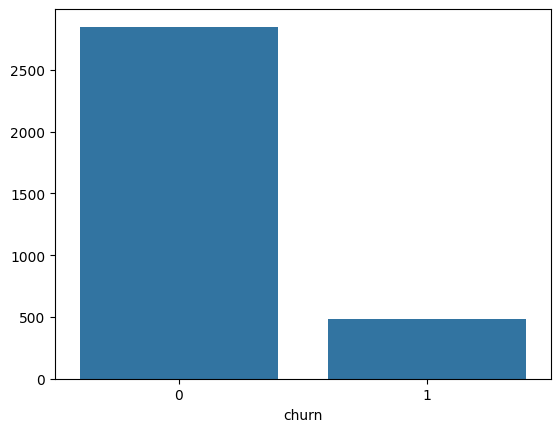

In [13]:
df['churn'].value_counts()
sns.barplot(x=df['churn'].value_counts().index, y=df['churn'].value_counts().values)
plt.show()

3. Feature Engineering:

In [14]:
# Total minutes
df['total minutes'] = df['total day minutes'] + df['total eve minutes'] + df['total night minutes']

# Total calls
df['total calls'] = df['total day calls'] + df['total eve calls'] + df['total night calls']

# Total charge
df['total charge'] = df['total day charge'] + df['total eve charge'] + df['total night charge']

# Average minutes per call
df['avg minutes per call'] = df['total minutes'] / df['total calls']

# Customer service calls per account length
df['service calls per length'] = df['customer service calls'] / df['account length']


Creates aggregated features from existing ones

In [15]:
# Check if the new features make sense
print(df[['total minutes', 'total day minutes', 'total eve minutes', 'total night minutes']].head())
print(df[['total charge', 'total day charge', 'total eve charge', 'total night charge']].head())

   total minutes  total day minutes  total eve minutes  total night minutes
0          707.2              265.1              197.4                244.7
1          611.5              161.6              195.5                254.4
2          527.2              243.4              121.2                162.6
3          558.2              299.4               61.9                196.9
4          501.9              166.7              148.3                186.9
   total charge  total day charge  total eve charge  total night charge
0         72.86             45.07             16.78               11.01
1         55.54             27.47             16.62               11.45
2         59.00             41.38             10.30                7.32
3         65.02             50.90              5.26                8.86
4         49.36             28.34             12.61                8.41


In [16]:

#  Drop original features that are now redundant
df.drop(['total day minutes', 'total eve minutes', 'total night minutes',
         'total day calls', 'total eve calls', 'total night calls',
         'total day charge', 'total eve charge', 'total night charge'], 
        axis=1, inplace=True)


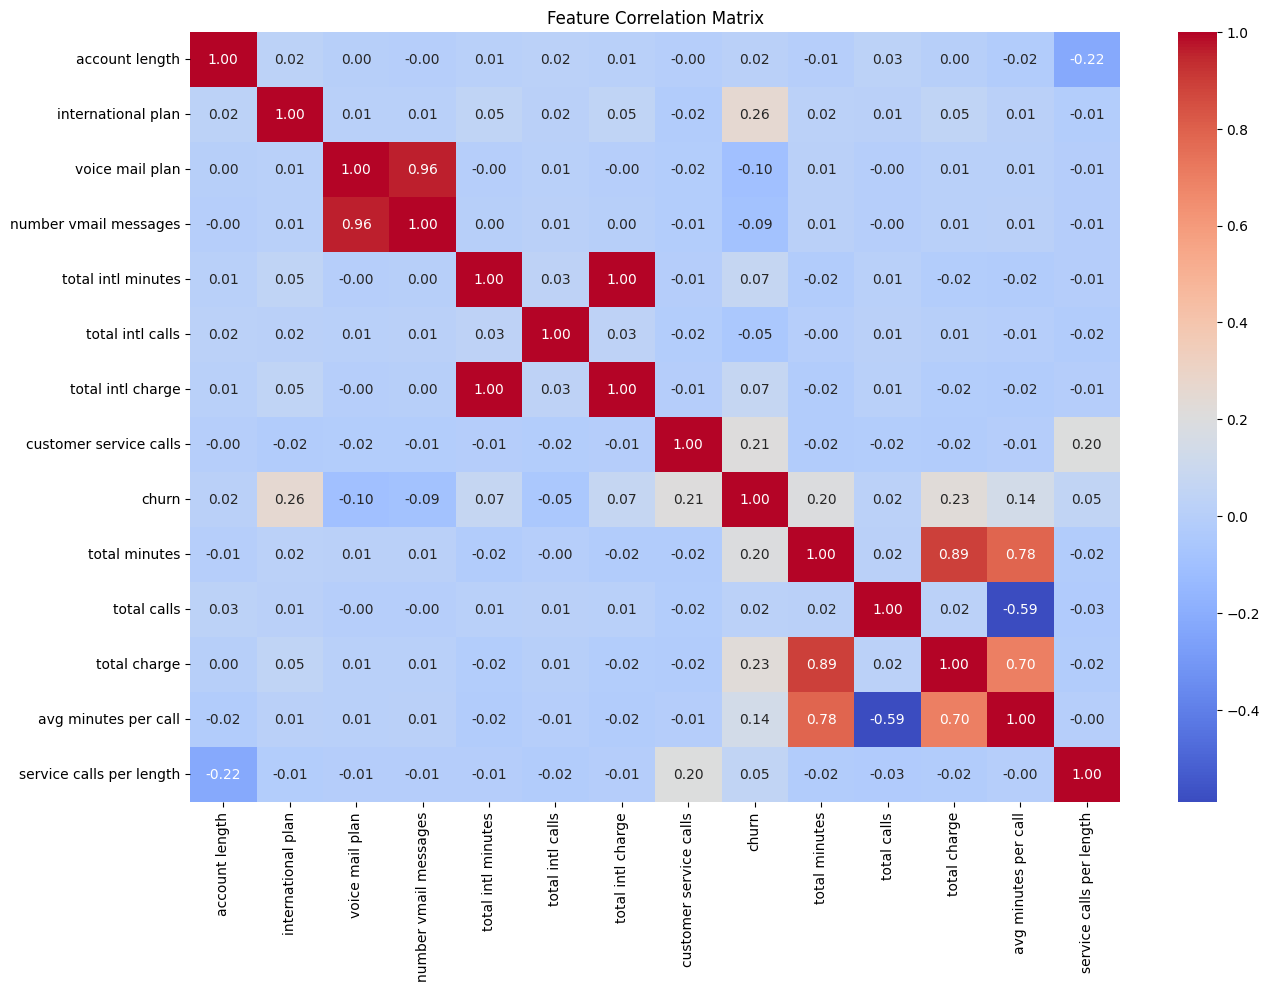

In [17]:
# Check correlation matrix
plt.figure(figsize=(15, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


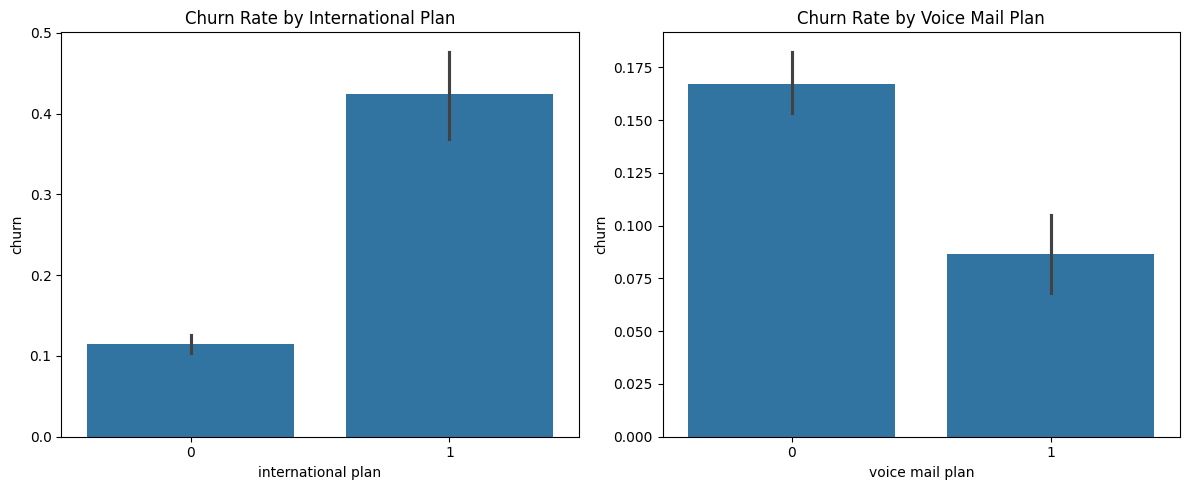

In [18]:
# Plot churn rate by international plan and voice mail plan
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x='international plan', y='churn', data=df, ax=axes[0])
axes[0].set_title("Churn Rate by International Plan")
sns.barplot(x='voice mail plan', y='churn', data=df, ax=axes[1])
axes[1].set_title("Churn Rate by Voice Mail Plan")
plt.tight_layout()
plt.show()


In [19]:
y = df["churn"].value_counts()
print(f"Churn Data :\n{y}\n")

# save all the rows where churn is True
y_True = df["churn"][df["churn"] == True]
print(y_True)

print ("\nChurn Percentage = "+str( (y_True.shape[0] / df["churn"].shape[0]) * 100 ))

Churn Data :
churn
0    2850
1     483
Name: count, dtype: int64

10      1
15      1
21      1
33      1
41      1
       ..
3301    1
3304    1
3320    1
3322    1
3323    1
Name: churn, Length: 483, dtype: int64

Churn Percentage = 14.491449144914492


In [20]:
print(df.columns.tolist())


['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'churn', 'total minutes', 'total calls', 'total charge', 'avg minutes per call', 'service calls per length']


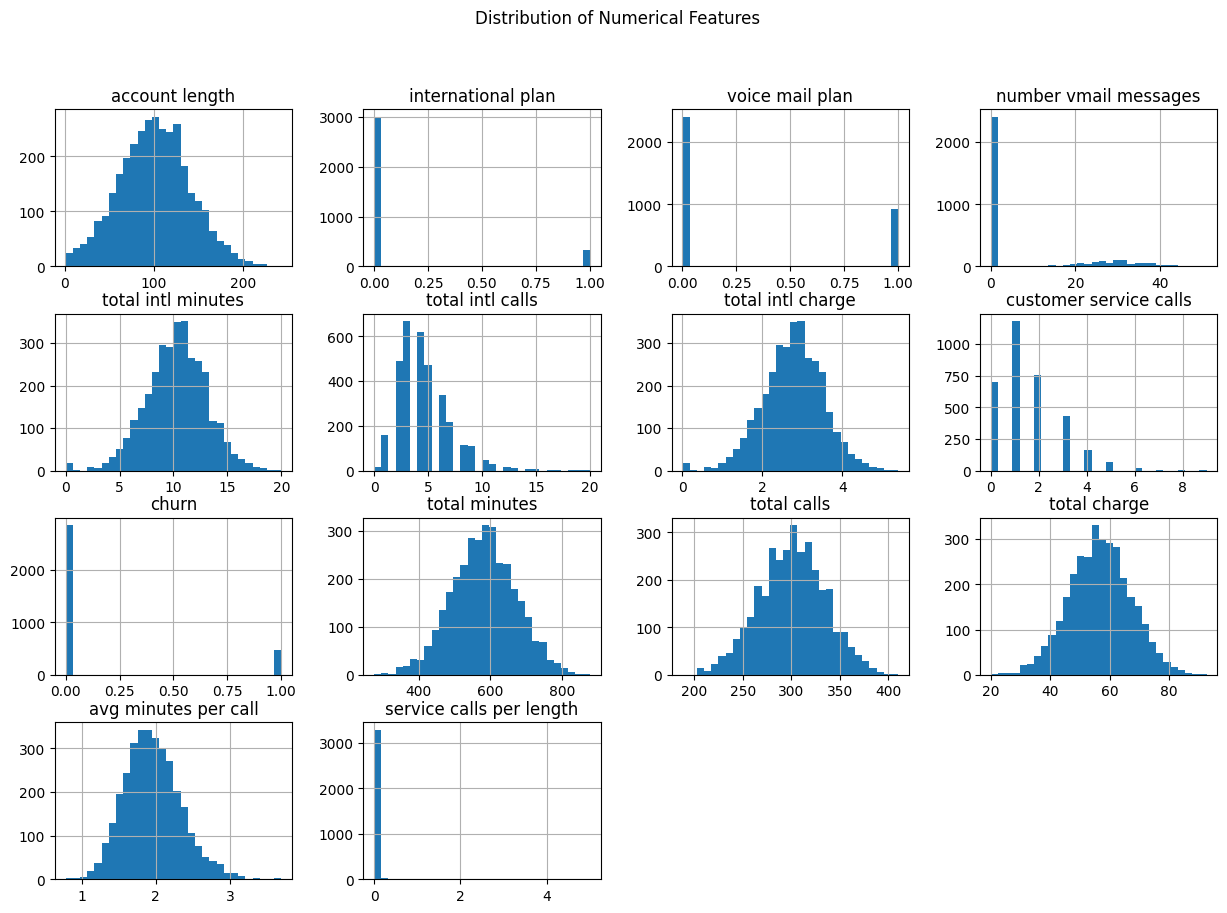

In [21]:
# Plot distribution of numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[numerical_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle('Distribution of Numerical Features')
plt.show()

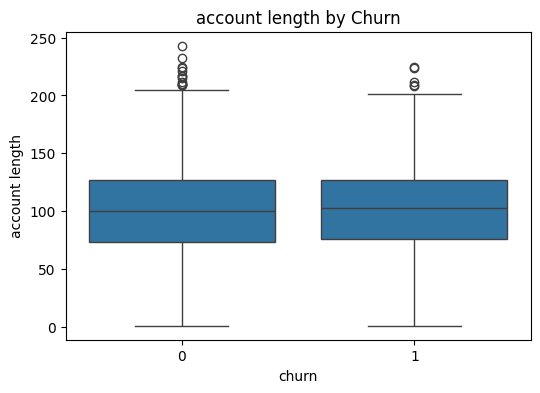

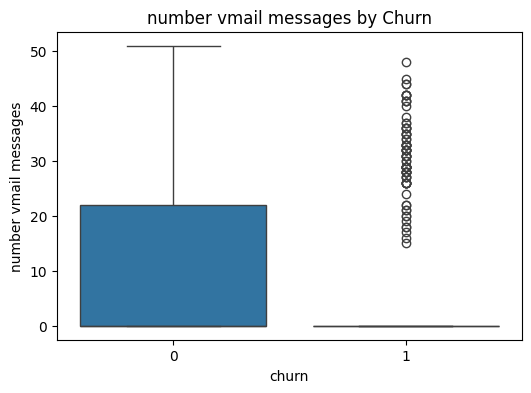

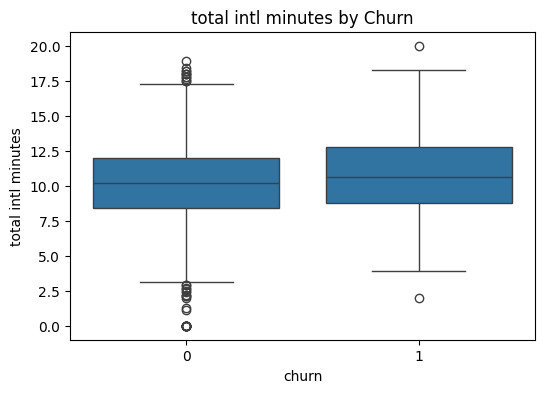

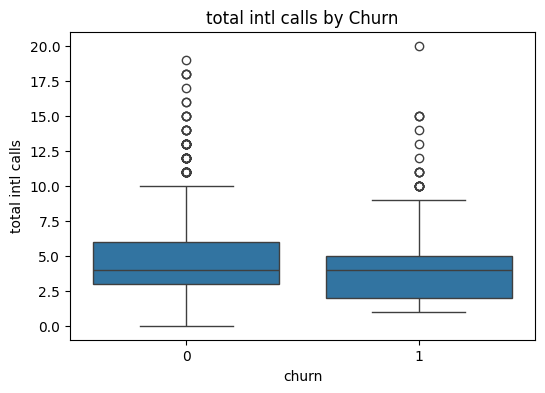

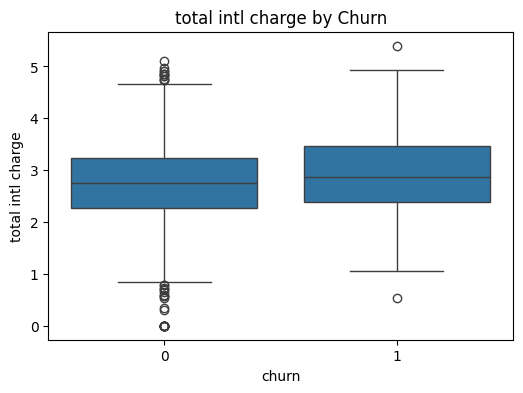

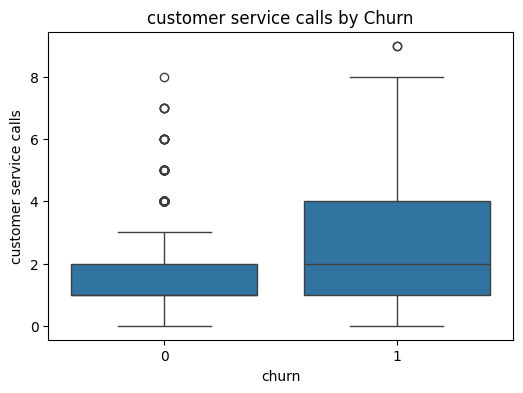

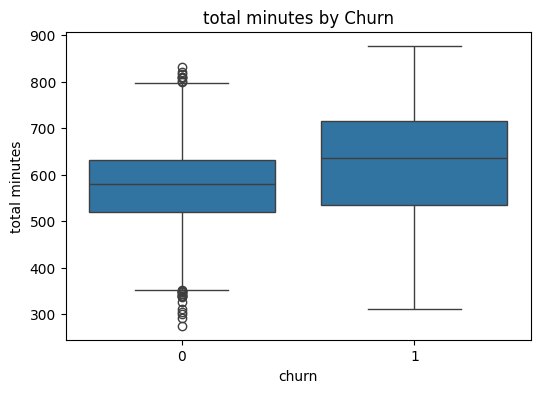

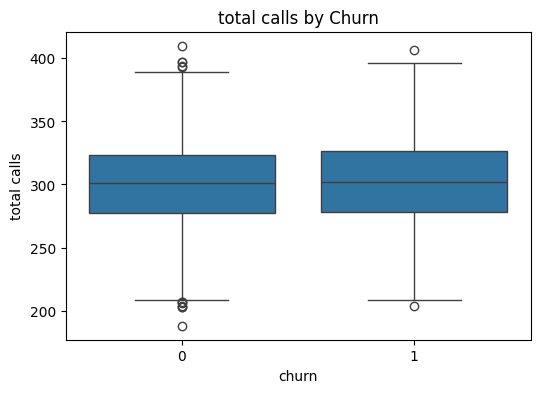

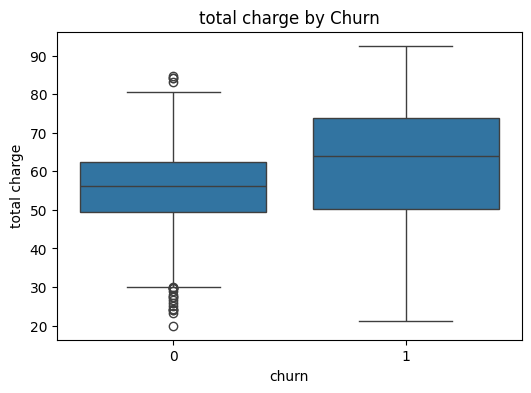

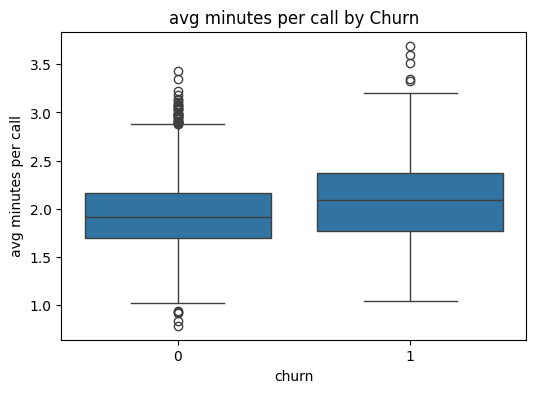

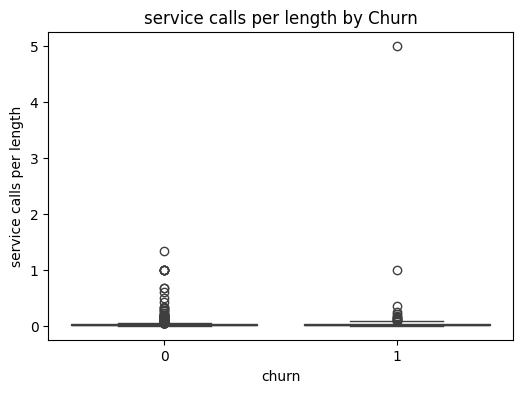

In [22]:
key_features = [
    'account length', 
    'number vmail messages', 
    'total intl minutes', 
    'total intl calls', 
    'total intl charge', 
    'customer service calls', 
    'total minutes', 
    'total calls', 
    'total charge',
    'avg minutes per call', 
    'service calls per length'
]
for feature in key_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='churn', y=feature, data=df)
    plt.title(f'{feature} by Churn')
    plt.show()



In [23]:

X = df.drop(columns="churn",axis=1)
y = df["churn"]

In [24]:
feature_columns = df.drop(columns=['churn']).columns
X = df[feature_columns]
y = df['churn']


In [25]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df

NameError: name 'X_test_scaled_df' is not defined

In [ ]:

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Check new class distribution
print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:", pd.Series(y_train_res).value_counts())

Before SMOTE: churn
0    2284
1     382
Name: count, dtype: int64
After SMOTE: churn
0    2284
1    2284
Name: count, dtype: int64


Before SMOTE
Class 0 (Not Churned): 2284 samples

Class 1 (Churned): 382 samples
> The dataset is highly imbalanced.

After SMOTE
Class 0 (Not Churned): 2284 samples

Class 1 (Churned): 2284 samples
> The dataset is now perfectly balanced.


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       566
           1       0.38      0.76      0.51       101

    accuracy                           0.78       667
   macro avg       0.67      0.77      0.68       667
weighted avg       0.86      0.78      0.80       667

ROC AUC Score: 0.8381030682573557


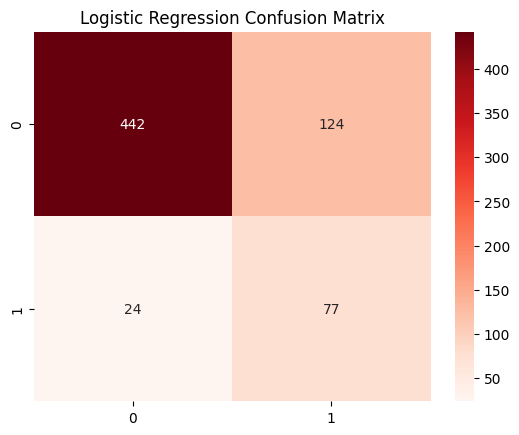


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       566
           1       0.69      0.87      0.77       101

    accuracy                           0.92       667
   macro avg       0.83      0.90      0.86       667
weighted avg       0.93      0.92      0.92       667

ROC AUC Score: 0.9003078753104992


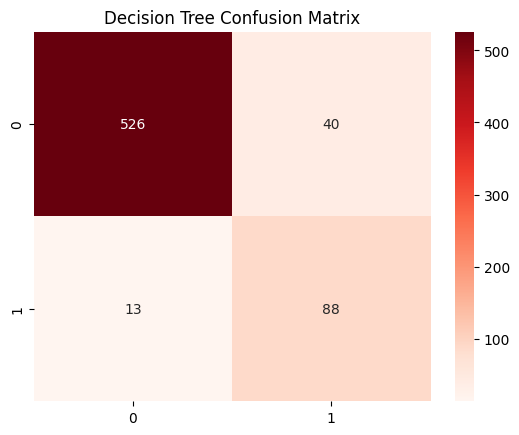

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

       Decision tree outperforms the Logistic Regression

       Logistic Regression recalls churners well 76% but is very imprecise 38%  it triggers many false churn alerts.

       Decision Tree maintains both high recall 87% and a more acceptable precision 69%, offering a better business trade-off.

       ROC AUC of 0.90 confirms that the tree model separates churners from non-churners more effectively.

In [ ]:
# Add constant to both train and test sets
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Train the model
model = sm.Logit(y_train, X_train_const).fit()

# Predict
y_pred_prob = model.predict(X_test_const)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred_class):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_class):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_class):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))


Optimization terminated successfully.
         Current function value: 0.323133
         Iterations 7
Accuracy: 0.8591
Precision: 0.6061
Recall: 0.1980
F1 Score: 0.2985

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       566
           1       0.61      0.20      0.30       101

    accuracy                           0.86       667
   macro avg       0.74      0.59      0.61       667
weighted avg       0.83      0.86      0.83       667



In [ ]:

# Instantiate the model
model = Ridge(alpha=100,solver="sag", random_state=1)

# Fit the model on the scaled training data
model.fit(X_train_scaled, y_train)


Ridge(alpha=100, random_state=1, solver='sag')

In [ ]:

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [ ]:

train_rmse = np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"""
RMSE
Train: {train_rmse} \t Test: {test_rmse}

R-squared
Train: {train_r2} \t Test: {test_r2}
""")


RMSE
Train: 0.3172984230863006 	 Test: 0.3253033906288639

R-squared
Train: 0.1798436435405707 	 Test: 0.17644796863587242



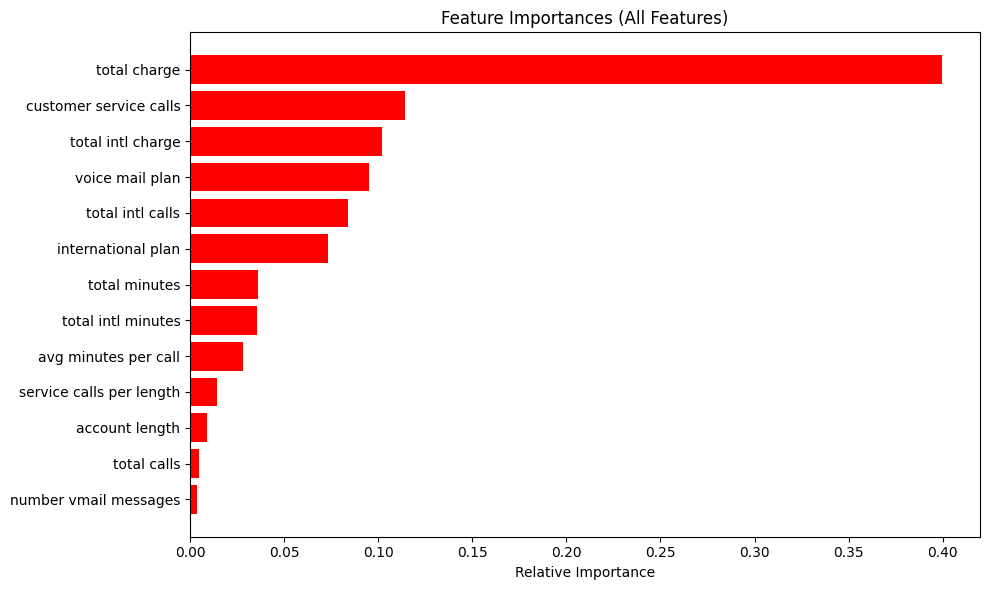

In [ ]:
# Get feature names and importances
feature_names = list(X_train.columns)
importances = decision_tree.feature_importances_

# Sort feature importances in ascending order
indices = np.argsort(importances)

# Plot all features
plt.figure(figsize=(10, 6))
plt.title('Feature Importances (All Features)')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()


In [ ]:
probas = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    probas[name] = y_proba


In [ ]:

# 4. Initialize models
dt = DecisionTreeClassifier(random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)


# 5. Train models on balanced data
dt.fit(X_train_res, y_train_res)
lr.fit(X_train_res, y_train_res)

# 6. Predict probabilities on test set
dt_probs = dt.predict_proba(X_test)[:, 1]
lr_probs = lr.predict_proba(X_test)[:, 1]

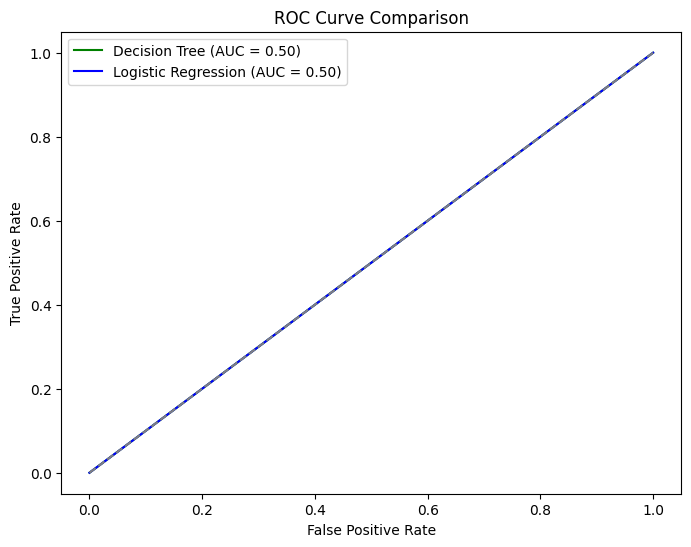

In [ ]:
# Compute ROC curves and AUCs
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
dt_auc = auc(dt_fpr, dt_tpr)
lr_auc = auc(lr_fpr, lr_tpr)

# 8. Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, color='green', label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot(lr_fpr, lr_tpr, color='blue', label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
#  Hyperparameter tuning for Decision Tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid,
                           scoring='roc_auc',
                           cv=3,
                           n_jobs=-1)

grid_search.fit(X_train_res, y_train_res)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validation AUC: {grid_search.best_score_:.3f}")

Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validation AUC: 0.962


In [ ]:
# Quick GridSearchCV tuning for Decision Tree
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid,
                           cv=3,
                           scoring='roc_auc',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validation AUC: {grid_search.best_score_:.3f}")

Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation AUC: 0.916


In [ ]:
y_proba_log = lr.predict_proba(X_test)[:, 1]
y_pred_log = lr.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]      
y_pred_dt = dt.predict(X_test)         

In [ ]:
# Calculate metrics
roc_auc_log = roc_auc_score(y_test, y_proba_log)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)

print(f"Logistic Regression AUC: {roc_auc_log:.4f}")
print(f"Decision Tree AUC: {roc_auc_dt:.4f}")

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt))


Logistic Regression AUC: 0.5000
Decision Tree AUC: 0.5000
Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       566
           1       0.15      1.00      0.26       101

    accuracy                           0.15       667
   macro avg       0.08      0.50      0.13       667
weighted avg       0.02      0.15      0.04       667

Decision Tree Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       566
           1       0.15      1.00      0.26       101

    accuracy                           0.15       667
   macro avg       0.08      0.50      0.13       667
weighted avg       0.02      0.15      0.04       667



In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[['international plan', 'voice mail plan']])

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_poly, y_train)

best_logistic = grid.best_estimator_

In [28]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [29]:
xgb_model.fit(X_train_poly, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)